In [1]:
from rasterio.features import rasterize
from rasterio.transform import from_origin
from glob import glob

import fiona
import numpy as np
import rasterio

In [2]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

In [3]:
geojson_files = glob('../AlertaDengue/static/geojson/*')[:10]
geojson_files

['../AlertaDengue/static/geojson/3200136.json',
 '../AlertaDengue/static/geojson/4128005.json',
 '../AlertaDengue/static/geojson/4121901.json',
 '../AlertaDengue/static/geojson/3204955.json',
 '../AlertaDengue/static/geojson/4127007.json',
 '../AlertaDengue/static/geojson/4125001.json',
 '../AlertaDengue/static/geojson/4106001.json',
 '../AlertaDengue/static/geojson/4120200.json',
 '../AlertaDengue/static/geojson/3301876.json',
 '../AlertaDengue/static/geojson/4104055.json']

In [4]:
# convert from geojson to shapefile
with fiona.open(geojson_files[0]) as geojson_file:
    with fiona.open(
        "/tmp/test.shp", "w",
        crs=geojson_file.crs, 
        driver="ESRI Shapefile", 
        schema=geojson_file.schema.copy()
    ) as shp:
        for item in geojson_file:
            shp.write(item)

In [5]:
#shp = fiona.open('zonas_farrapos.shp')
shp = fiona.open('/tmp/test.shp')

In [6]:
res = 0.01

width = (shp.bounds[2] - shp.bounds[0]) // res
height = (shp.bounds[3] - shp.bounds[1]) // res

out_shape = int(height), int(width)
out_shape

(30, 34)

In [7]:
transform = from_origin(shp.bounds[0] - res / 2,
                        shp.bounds[3] + res / 2, res, res)
transform

Affine(0.01, 0.0, -40.9109984980232,
       0.0, -0.01, -18.836515214274097)

In [8]:
rgb_values = hex_to_rgb('#ff0000')
rgb_values

(255, 0, 0)

In [9]:
shapes = [
    [(geometry['geometry'], color)]
    for k, geometry in shp.items()
    for color in rgb_values
]

In [10]:
# shapes = [(geometry['geometry'], k) for k, geometry in shp.items()]

In [11]:
dtype = rasterio.float64
fill = -1

raster_args = dict(
    out_shape=out_shape,
    fill=fill,
    transform=transform,
    dtype=dtype,
    all_touched=True
)

rasters = [rasterize(shape, **raster_args) for shape in shapes]

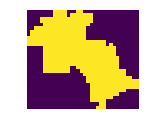

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(rasters[0])
ax.axis('off');

Salvar o geotiff.

In [13]:
with rasterio.open(
    fp='/tmp/test.tif', 
    mode='w',
    crs=shp.crs,
    driver='GTiff',
    profile='GeoTIFF',
    dtype=dtype,
    count=3,
    width=width,
    height=height,
    nodata=fill,
    transform=transform,
    photometric='RGB'
) as dst:
    # help(dst.write)
    for i in range(1, 4):
        dst.write_band(i, rasters[i-1])
        # dst.write_colormap(
        #     i, {0: (255, 0, 0), 255: (0, 0, 255)}
        # )
        # print(dst.colormap(i))

Round-trip

In [14]:
with rasterio.open('/tmp/test.tif') as src:
    r, g, b = src.read()
    print(src.width, src.height)
    print(src.crs)
    print(src.transform)
    print(src.count)
    print(src.indexes)
    print(src.colorinterp(1))
    print(src.colorinterp(2))
    print(src.colorinterp(3))
    
    bands = (
        ('r', r),
        ('g', g),
        ('b', b)
    )
    
    for k, band in bands:
        print('\n', k, ':')
        print('min:', np.min(band))
        print('max:', np.max(band))

34 30
CRS({'init': 'epsg:4326'})
| 0.01, 0.00,-40.91|
| 0.00,-0.01,-18.84|
| 0.00, 0.00, 1.00|
3
(1, 2, 3)
ColorInterp.red
ColorInterp.green
ColorInterp.blue

 r :
min: -1.0
max: 255.0

 g :
min: -1.0
max: 0.0

 b :
min: -1.0
max: 0.0


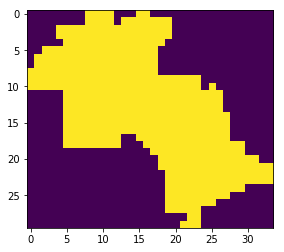

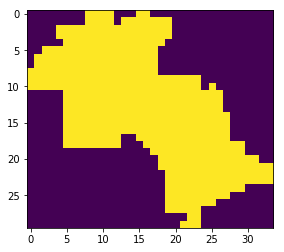

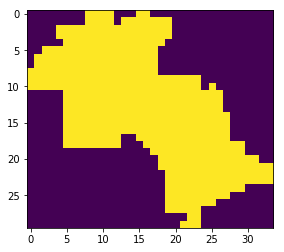

In [15]:
total = np.zeros(r.shape)
for band in r, g, b:
    plt.imshow(band)
    plt.show()
    total += band
# total /= 4

Aparentemente a figura "preta" é pq não tenho um visualizador corrento.
A `tif` parece OK mesmo salvando em 3 bandas.

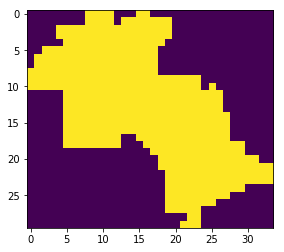

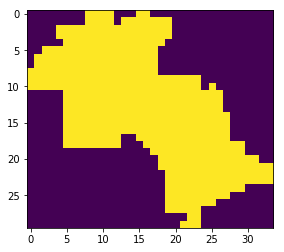

In [16]:
plt.imshow(total)
plt.show()

plt.imshow(total/3)
plt.show()

In [17]:
import pandas as pd
pd.DataFrame(total/3)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,85.0,85.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,85.0,85.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,85.0,85.0,85.0,85.0,85.0,85.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,85.0,85.0,85.0,85.0,85.0,85.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,85.0,85.0,85.0,85.0,85.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,-1.0,-1.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,-1.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,-1.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# Refs

https://github.com/mapbox/rasterio/blob/6b02fd304d10995cff818729abe47f28bd7a33b5/examples/rasterize_geometry.py